In [2]:
from ioMicro import *

In [3]:
save_folder =r'\\192.168.0.10\bbfishdc13\DCBBL1_3_2_2023\MERFISH_Analysis'
save_fls = glob.glob(save_folder+os.sep+'finaldecs_*--*.npz')

In [140]:
save_fls_ = [fl for fl in save_fls if ('_set1' in fl) or ('_set2' in fl)]# in fl if '035' in fl][0]
cell_df,df=None,None
for save_fl in tqdm(np.sort(save_fls_)[:]):
    ### load info
    dic = np.load(save_fl)
    XF = dic['XF']
    header = list(dic['header'])
    genes_decoded = dic['genes']
    cells = dic['cellinfo'][1:]
    header_cells = dic['header_cells']
    ### Rethrehold based on score
    iscore = list(header).index('score')
    scoreA = XF[:,iscore]
    keep = scoreA>-1
    ugns,gns_i = np.unique(genes_decoded[keep],return_inverse=True)

    icell = header.index('cell_id')
    icells = XF[keep,icell].astype(int)
    
    icellsf = cells[:,0].astype(int)
    
    mcell = np.max(icellsf)+1
    gn_cell,gn_cell_cts = np.unique(mcell*gns_i+icells,return_counts=True)
    len(gn_cell)
    igns_ = gn_cell//mcell
    icells_ = gn_cell%mcell
    Mcts = np.zeros([mcell,len(ugns)])
    Mcts[icells_,igns_]=gn_cell_cts

    Mcts[icellsf].shape
    ifov,iset = int(XF[0,header.index('ifov')]),int(XF[0,header.index('iset')])
    icellsnm = [icell+10**5*ifov+10**9*iset for icell in icellsf]

    dfT = pd.DataFrame(Mcts[icellsf],columns=ugns,index=icellsnm)


    df = dfT if df is None else pd.concat([df,dfT])
    cell_dfT = pd.DataFrame(cells,columns=header_cells,index=icellsnm)
    cell_df = cell_dfT if cell_df is None else pd.concat([cell_df,cell_dfT])

100%|████████████████████████████████████████████████████████████████████████████████| 673/673 [05:28<00:00,  2.05it/s]


In [273]:
genes_ = list(df.columns)
#cell_df
bad_i = [ign for ign,gn in enumerate(genes_) if 'blank' in gn]
cell_mean_blank = np.nanmax(df.iloc[:,bad_i],axis=1)
good_cells = cell_mean_blank<5

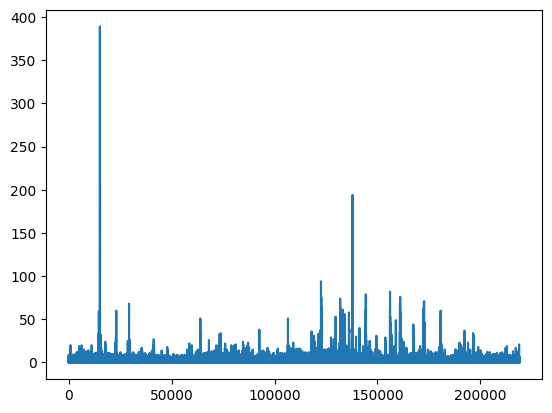

In [274]:
plt.plot(cell_mean_blank)

In [228]:
np.mean(np.nansum(df,axis=1))

582.9528497456645

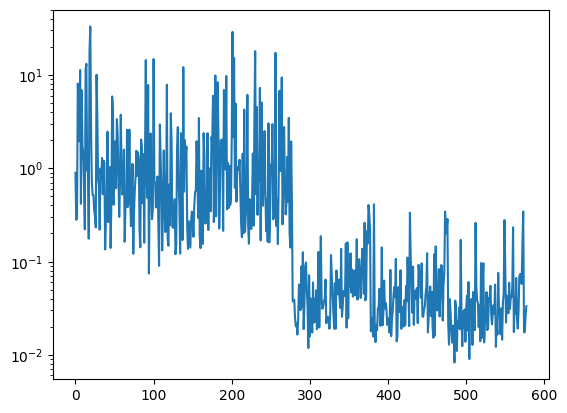

In [223]:
plt.semilogy(np.nanmean(df,axis=0))

In [291]:
xcells = cell_df['xc']*0.10833*4+cell_df['yfov']
ycells = cell_df['yc']*0.10833*4-cell_df['xfov']
Xcells = np.array([xcells,ycells]).T
for gene in tqdm(genes_):
    #gene = 'Aldoc'
    cts = np.array(df[gene])#Ptbp1_smFISH
    cts[np.isnan(cts)]=0
    ncts = np.clip(cts/10,0,1)
    size = 5+ncts*30
    from matplotlib import cm as cmap
    cols = cmap.coolwarm(ncts)

    viewer = napari.view_points(-Xcells[good_cells,::-1],size=size[good_cells],face_color=cols[good_cells],name=gene)
    viewer.screenshot(path=r'D:\DCBBL1_3_2_2023Figures'+os.sep+gene+'.png',size=[1000,1000],scale=5)
    viewer.close()

100%|████████████████████████████████████████████████████████████████████████████████| 578/578 [59:50<00:00,  6.21s/it]


In [ ]:
scdata2 = sc.AnnData(count_table2)
scdata2.obsm["X_spatial"] = Xcells[good_cells][:,::-1]
gfp_genes = [ign for ign,gn in enumerate(gns_all) if np.any([e in gn.lower() for e in ['gfp']])]
scdata2.obsm["GFP"] = cts_all[good_cells][:,gfp_genes]
blank_genes = [ign for ign,gn in enumerate(gns_all) if np.any([e in gn.lower() for e in ['blank']])]
scdata2.obsm["blank"] = cts_all[good_cells][:,blank_genes]

sc.pp.filter_cells(scdata2, min_genes=5)
scdata2.obsm["X_raw"] = scdata2.X.copy()
sc.pp.calculate_qc_metrics(scdata2, percent_top=None, inplace=True)
sc.pp.normalize_total(scdata2, target_sum=np.median(scdata2.obs["total_counts"]))

### Tried volume normalization but did not work well.

#volume = np.array(list(celldata['volume'].reindex(index=scdata.obs.index.astype(int))),dtype=np.float)
#scdata.X = scdata.X/volume[:,np.newaxis]*np.median(volume)

sc.pp.log1p(scdata2)

#scdata2.X = scdata2.to_df().apply(zscore, axis=0).to_numpy()

### Should we use PCA?

### Should we do z-scores. Explore this with spatial maps. Visual inspection.

sc.pp.neighbors(scdata2,use_rep = "X")  #metric='correlation', use_rep = "X"

NameError: name 'ncts' is not defined

In [153]:
len(cell_df)

219002

In [141]:

import napari
napari.view_points(Xcells)

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 723.9267578125, -2459.279846191407), zoom=0.05129473573202182, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=2, ndisplay=2, last_used=0, range=((-4878.5, 6327.353515625, 1.0), (-5780.0537109375, 862.4940185546875, 1.0)), current_step=(5602, 3322), order=(0, 1), axis_labels=('0', '1')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Points layer 'Xcells' at 0x257a211da90>], scale_bar=ScaleBar(visible=False, colored=False, color=array([1., 0., 1., 1.], dtype=float32), ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, box=False, box_color=array([0. , 0. , 0. , 0.6], dtype=float32), unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 1. ], dtype=float32), font_size=10.0, posit

,cell_id,volm,zc,xc,yc,xfov,yfov
1003500001,1.0,3617.0,2.501244,8.460879,340.129944,866.700012,779.200012
1003500005,5.0,1867.0,2.217461,13.653455,111.948578,866.700012,779.200012
1003500008,8.0,1750.0,4.359428,46.380001,210.994858,866.700012,779.200012
1003500009,9.0,5935.0,3.522325,53.455265,638.689453,866.700012,779.200012
1003500012,12.0,6049.0,2.940321,62.216896,580.279053,866.700012,779.200012
...,...,...,...,...,...,...,...
1003500448,448.0,888.0,6.719594,726.266907,16.296171,866.700012,779.200012
1003500449,449.0,303.0,6.000000,726.924072,41.244225,866.700012,779.200012
1003500450,450.0,665.0,6.542857,454.024048,57.045113,866.700012,779.200012
1003500452,452.0,472.0,7.000000,49.745762,113.188560,866.700012,779.200012


In [106]:
len(ugns)

559

In [92]:
dic['cellinfo'].shape

(393, 7)

In [93]:
dic['header_cells']

array(['cell_id', 'volm', 'zc', 'xc', 'yc', 'xfov', 'yfov'], dtype='<U7')

In [90]:
list(dic.keys())

['XF', 'genes', 'cellinfo', 'header_cells', 'header']

In [88]:
import pandas as pd
10**5*

In [87]:
#import pandas as pd

In [64]:
len(icells),len(gns_i)
ucells = np.unique(icells)
ndimage.sum(icells,ucells)

(316535, 316535)

In [58]:
ugns,gns_i = np.unique(genes_decoded,return_inverse=True)
genes_decoded

array(['Mbp', 'Atp1a2', 'Ntrk2', ..., 'Ptbp1_smFISH', 'Ptbp1_smFISH',
       'Ptbp1_smFISH'], dtype='<U14')

In [51]:
ugenes = np.unique(genes_decoded)


In [ ]:
XF = dic['XF']

In [4]:
len(save_fls)

1276

In [13]:
save_fl = [fl for fl in save_fls if '_set1' in fl if '035' in fl][0]
dic = np.load(save_fl)
XF = dic['XF']
header = dic['header']
genes_decoded = dic['genes']

In [19]:
iscore = list(header).index('score')
scoreA = XF[:,iscore]
keep = scoreA>-1
gns,cts = np.unique(genes_decoded[keep],return_counts=True)

In [39]:
gns[np.argsort(cts)[::-1]][:60]

array(['Adcy1', 'Atp1b1', 'Slc1a2', 'Psap', 'Atp1a2', 'Gnb1', 'Thy1',
       'Nrgn', 'Unc13a', 'Prox1', 'Ntrk2', 'Trim2', 'Gabbr1', 'Aldoc',
       'Nr3c2', 'Mbp', 'Smarca4', 'C1ql3', 'Adgrl3', 'Bhlhe22', 'Actb',
       'Gad1', 'Adarb2', 'Bsg', 'Auts2', 'Bsn', 'Cspg5', 'Kcnd2',
       'Ptbp1_smFISH', 'Olig1', 'Gpc4', 'Stox2', 'Tenm2', 'Dgkb',
       'Zbtb20', 'Ptbp1', 'Pde10a', 'Actg1', 'Ahcyl2', 'Aldh1l1_smFISH',
       'Lrp1b', 'Rasl10a', 'Nfia', 'Mapk4', 'Foxg1', 'Neurod1', 'Unc5c',
       'Cldn5', 'Rtn4', 'Opcml', 'Vps13c', 'Csmd1', 'Cst3', 'Nrg3',
       'Frmd4a', 'Mcu', 'Dgkh', 'Slc2a1', 'Mfge8', 'Padi2'], dtype='<U14')

In [59]:
plot_multigenes2(XF,header,genes_decoded,genes=['Ptbp1','Ptbp1_smFISH'],colors=['r','g','b','m','c','y','w'],th=-1,smin=5,smax=20,viewer = None,
                    drift=[0,0,0],resc=[1,1,1])

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 1537.1266822814941, 1551.154281616211), zoom=0.3989904325613158, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(20.490666389465332, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((4.490666389465332, 35.6755256652832, 1.0), (88.28241729736328, 2989.3095703125, 1.0), (114.71652221679688, 2997.97314453125, 1.0)), current_step=(16, 1449, 1436), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Points layer 'Ptbp1' at 0x25796bb6df0>, <Points layer 'Ptbp1_smFISH' at 0x25796be43d0>], scale_bar=ScaleBar(visible=False, colored=False, color=array([1., 0., 1., 1.], dtype=float32), ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, box=False, box_color=array([0. , 0. , 0. , 0.6], dt

In [32]:
def plot_multigenes2(XF,header,genes_decoded,genes=['Olig1','Sox9'],colors=['r','g','b','m','c','y','w'],th=-1,smin=3,smax=10,viewer = None,
                    drift=[0,0,0],resc=[1,1,1]):
    iscore = list(header).index('score')
    scoreA = XF[:,iscore]
    
    Xcms = XF
    keep = scoreA>th
    X = (Xcms[:,:3][keep]-drift)/resc  
    H = scoreA[keep]
    H -= np.min(H)
    icodesf = genes_decoded[keep]
    size = smin+np.clip(H/np.max(H),0,1)*(smax-smin)
    
    if viewer is None:
        import napari
        viewer = napari.Viewer()
    for igene,gene in enumerate(genes):
        color= colors[igene%len(colors)]
        #icode = gns_names.index(gene)
        is_code = gene==icodesf
        viewer.add_points(X[is_code],size=size[is_code],face_color=color,name=gene)

    return viewer

In [33]:
np.savez_compressed(save_fl,XF=XF_.astype(np.float32),
                                genes = genesf_,cellinfo=cellinfo.astype(np.float32),header_cells=header_cells,header=header)

NameError: name 'XF_' is not defined

In [ ]:
np.load(save_fl)